In [ ]:
# init repo notebook
!git clone https://github.com/rramosp/ppdl.git > /dev/null 2> /dev/null
!mv -n ppdl/content/init.py ppdl/content/local . 2> /dev/null
!pip install -r ppdl/content/requirements.txt > /dev/null

# Model-based reasoning and Bayesian inference

In model-based reasoning we assume a model of the process that generated our data. In Bayesian inference this model is probabilistic in nature, i.e. it encodes our knowledge (or asumptions) of the world in terms of ramdom variables, probabilistic distributions of these random variables and dependence/independence realtionships.

The following is a summary of the Bayesian approach to machine learning (https://www.cs.toronto.edu/~radford/ftp/bayes-tut.pdf):

1. **Model formulation**: We formulate our knowledge about the world (or the mechanism that generated our data) probabilistically:
 - We define a *model* that express qualitative aspects of our knowledge. This model will be expressed in terms of random variables and their relationships. The model will have unknown parameters. 
 - We specify our believes (before seeing any data) about how we expect the values of the unknown parameters to behave using a *prior* probability.
2. **Data collection**: We obtain data.
3. **Posterior calculation**: We use the data to compute the *posterior* probability of the unknown parameters, given the observed data.
4. **Model application**: The posterior probability distribution can be used to:
  - Derive scientific conclusions, taking into account uncertainty.
  - Make predictions.
  - Make decisions.

To illustrate this process, we will a coin flipping experiment as an example.

# Coin flipping example

In this example, we want to model the toss of a coin using a Bayesian approach. 

### 1. Model formulation

Our model will have two random variables:

$Y$: random variable representing the outcome of a coin toss

$\Theta$: probability of getting a head ($Y=1$)

The distribution of $Y$ is Bernoulli:
$$
P(Y = y\ |\ \theta) = \theta^{y}(1 - \theta)^{1 - y}
$$

An experiment consists of performing several coin tosses. The resulting data, $D$, from the experiment can be summarized by two values: $#heads$ and $#tails$. The likelihood of a particular experiment outcome is given by the binomila distribution:

$$
\begin{align}
P(D\ |\ \theta) &= \binom{\#heads + \#tails}{\#heads} \theta^{\#heads}(1 - \theta)^{\#tails}
\end{align}
$$

This term is called the *likelihood*, the conditional probability of the data given the parameters. The following Python function calculates it:

In [14]:
from scipy.special import comb
def likelihood(num_heads, num_tails, theta):
    return (comb(num_heads + num_tails, num_heads) 
            * theta ** num_heads 
            * (1. - theta) ** num_tails)

For instance if $\theta = 0.3$, the probability of getting 6 heads and 4 tails in 10 coin tosses would be:

In [15]:
likelihood(6, 4, 0.3)

0.03675690899999999

But if $\theta=0.8$ the likelihood would be:

In [16]:
likelihood(6, 4, 0.8)

0.08808038399999996


As part of our modeling we have to also represent our prior knowledge of the possible values of $\theta$. This is encoded by a distribution of $\theta$ values which is called the prior distribution:

$$
P(\theta)
$$

If we don't have any prior knowledge, this can be encoded as a uniform prior distribution. Since we are dealing with a coin, we can assume that coins that are closer to be fair are more likely, this means that we give higher probabilities to values of $\theta$ closer to $0.5$. Also we will assume a discrete probability since it will simplify our calculations: 



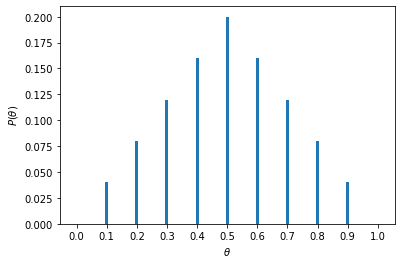

In [17]:
import numpy as np
import matplotlib.pyplot as plt


def theta_prior_fun():
    theta_vals = np.linspace(0, 1, 11)
    theta_prior_p = np.concatenate([np.arange(0, 6), np.arange(4, -1, -1)])
    theta_prior_p = theta_prior_p / np.sum(theta_prior_p)
    theta_prior = {theta_vals[i]:theta_prior_p[i] for i in range(len(theta_vals))}
    return theta_prior

def plot_theta_dist(theta_vals, theta_p):
    ind = np.arange(len(theta_vals))
    fig, ax = plt.subplots()
    ax.bar(ind, theta_p, width=0.1 )
    ax.set_xticks(ind)
    ax.set_xticklabels([f'{val:.1f}' for val in theta_vals])
    ax.set_xlabel(r'$\theta$')
    ax.set_ylabel(r'$P(\theta$)')
    
theta_prior = theta_prior_fun()
theta_vals = np.linspace(0, 1, 11)
theta_p = [theta_prior[val] for val in theta_vals]
plot_theta_dist(theta_vals, theta_p)

## 2. Data collection

Two collect data we can toss a real coin a number of times and record how many 
heads ($\# heads$) and tails ($\# tails$) we get. This is our data $D$. For this exercise let's assume we got  $\# heads = 15$ and $\# tails = 5$.

## 3. Posterior calculation

To calculate the posterior we will use the the Bayes theorem:

$$
P(\theta|D) = \frac{P(D|\theta)P(\theta)}{P(D)}
$$

We already have the prior distribution and the likelihood function. We need to calculate the probability of the evidence (our data $D$). For this we will use the law to total probability, taking advantage of the fact that the prior distribution is discrete and only takes values greater than 0 for a finite set of theta values $\{\theta_0\dots\theta_{n-1}\}$ :

$$
\begin{align}
P(D) &= \sum_{i}{P(D,\theta=\theta_i)} \\
 & = \sum_{i}{P(D\ |\ \theta=\theta_i)P(\theta = \theta_i)} \\
\end{align}
$$

In [18]:
def evidence(num_heads, num_tails, theta_vals):
    joints = [likelihood(num_heads, num_tails, theta_i) * theta_prior[theta_i]
              for theta_i in theta_vals]
    return sum(joints)

Now, we are prepared for defining the posterior distribution function ($P(\theta|D)$):

In [19]:
def posterior(num_heads, num_tails, theta_vals):
    evidence_p = evidence(num_heads, num_tails, theta_vals)
    posterior_p = {theta_i:likelihood(num_heads, num_tails, theta_i) 
                            * theta_prior[theta_i] / evidence_p
                   for theta_i in theta_vals}
    return posterior_p



Now we call the function with our data and plot the resulting posterior distribution:

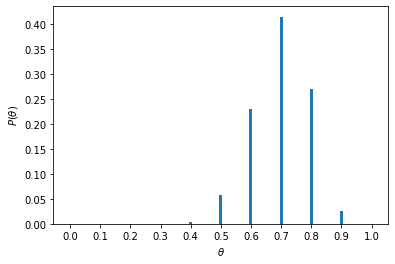

In [20]:
theta_posterior = posterior(15, 5, theta_vals)
theta_p = [theta_posterior[val] for val in theta_vals]
plot_theta_dist(theta_vals, theta_p)

## 4. Model application

We can see that the resulting posterior distribution gives higher probability to values of the parameter around $0.7$, this is consistent with the fact that the data from the experiment has more heads than tails. 

If we want to make a prediction of the outcome of a new coin toss, we can do it in different ways. We can use the mode of the posterior distribution, i.e.:

$$
\theta_{\text{MAP}} = \arg \max_\theta P(\theta|D)
$$

This is called maximum a posteriori estimation (MAP). The following Python function calculates the MAP estimator for a given posterior distribution:


In [26]:
def map_estimator(posterior_p):
    items = np.array(list(map(list, posterior_p.items())))
    return items[np.argmax(items[:, 1]), 0]



0.7000000000000001


In our example the MAP estimator will be:

In [27]:
print(map_estimator(theta_posterior))

0.7000000000000001


Which means that the probability of getting heads in the new experiment will be:

$$
P(Y=1|\theta = \theta_{\text{MAP}}) = \theta_{\text{MAP}} = 0.7
$$

Another possibility is to calculate the expected value of $\theta$:

$$
\theta_{\text{Bayes}} = E[\theta]
$$

This is called the Bayes estimator. The following Python function calculates the Bayes estimator:

In [30]:
def bayes_estimator(posterior_p):
    items = np.array(list(map(list, posterior_p.items())))
    return np.dot(items[:, 0], items[:, 1])



In our example the Bayes estimator will be:

In [31]:
print(bayes_estimator(theta_posterior))

0.6961813468955773


The probability of getting heads in the new experiment according to this estimator will be:

$$
P(Y=1|\theta = \theta_{\text{Bayes}}) = \theta_{\text{Bayes}} = 0.6961
$$
